<a href="https://colab.research.google.com/github/Jonathan-C-Barrett/GEOG5990M/blob/main/GEOG5003M_Final_Project_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GEOG5003M Final Assignment

Student ID number: 201804755

GitHub repo link: https://github.com/Jonathan-C-Barrett/GEOG5990M/tree/main

Word count limit= 1,500 words max (markdown cells only, excluding readme)

# Read in Packages

In [ ]:
#Install required packages
!pip install mapclassify
!pip install contextily
!pip install geoplot
!pip install git+https://github.com/pmdscully/geo_northarrow.git


# read in required packages
import geopandas as gpd
import pandas as pd
# remove default='warn' for chained assigments
pd.options.mode.chained_assignment = None
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
from geo_northarrow import add_north_arrow



# import the required machine learning packages
from sklearn import cluster
from sklearn.preprocessing import scale





# Pre-processing

The following was required for pre-processing.

First was the selection of appropriate variables from the access to services dataset. These were selected based on services directly linked to personal health, including leisure facilities which support healthiness <a href="#ref1">[1]</a>. Using these five variables a weighted average was created, with weights based on previous studies of services with the largest impact <a href="#ref1">[1]</a>, and stored under the code ‘ah4h’.

Second was to deal with missing values, either from individual quarters or the entire year, of the median property data. A yearly mean column under ‘2016_mean’ was created and populated with the mean value of the combined quarterly values. This negated the issue with missing quarterly data while additionally benefiting from the removal of seasonal impact on house pricing <a href="#ref2">[2]</a>. After creating the mean value, for any rows that remained missing due to a complete missing year, these were removed as there was no way to extrapolate the data accurately from elsewhere.

Following this area codes were converted from LSOA11 to LSOA21 by combining the data with a conversion data frame, where we then also removed unnecessary columns to make the data frame less cluttered.

To investigate outliers in the data, descriptive statistics, pair plots and box plots were used. Although all data sets showed some evidence of extreme values, property value showed extreme outliers at the larger end and so these were identified and removed using the interquartile range method. This method was used due to its simplicity and reproducibility at removing outliers so as not to distort the results of the correlation <a href="#ref3">[3]</a>.


**HEALTH SERVICE ACCESS DATA**

In [8]:
#Read in Health Services Data
#Data sourced from: https://data.geods.ac.uk/dataset/access-to-healthy-assets-hazards-ahah
ahah = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/ahah_v4.csv')
ahah.head()

,LSOA21CD,ah4blue,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4pubs,ah4ffood,ah4gpas,...,ah4g_rnk,ah4e_rnk,ah4r_rnk,ah4h_pct,ah4g_pct,ah4e_pct,ah4r_pct,ah4ahah,ah4ahah_rnk,ah4ahah_pct
0,E01000001,1.8048,0.6328,1.0316,0.9581,0.7487,0.3596,0.4210,0.3920,0.1056,...,40830,42589,41495,2,96,100,98,59.7543,42592,100
1,E01000002,2.1041,0.6230,1.3232,1.1370,0.6849,0.5571,0.4852,0.3946,0.0778,...,42201,42590,41673,4,99,100,98,65.4344,42635,100
2,E01000003,2.2753,0.5709,0.8562,0.7862,0.5919,0.4608,0.5679,0.5919,0.1339,...,40631,42590,40857,1,96,100,96,57.4313,42559,100
3,E01000005,1.1553,0.8337,1.1078,0.8697,0.6657,0.3717,0.2673,0.2934,0.0774,...,40765,42616,42419,2,96,100,100,64.3384,42629,100
4,E01000006,1.9055,1.9361,0.9587,1.5191,1.3641,1.5219,1.5017,1.1499,0.3310,...,23517,41369,34909,22,56,98,82,33.5326,38389,91


In [9]:
#Select only columns relating to Health Services
health = ahah[['LSOA21CD', 'ah4dent', 'ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis']]
health.head()

,LSOA21CD,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis
0,E01000001,0.6328,1.0316,0.9581,0.7487,0.3596
1,E01000002,0.6230,1.3232,1.1370,0.6849,0.5571
2,E01000003,0.5709,0.8562,0.7862,0.5919,0.4608
3,E01000005,0.8337,1.1078,0.8697,0.6657,0.3717
4,E01000006,1.9361,0.9587,1.5191,1.3641,1.5219


In [10]:
#check for missing values
health.isna().sum()

,0
LSOA21CD,0
ah4dent,0
ah4gp,0
ah4hosp,0
ah4phar,0
ah4leis,0


In [11]:
#explore general statistics
health.describe()

,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis
count,42648.000000,42648.000000,42648.000000,42648.000000,42648.000000
mean,3.598494,3.303977,3.899364,2.778768,5.350836
std,5.618716,3.562526,5.804335,3.504363,9.059330
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.346175,1.419900,1.339400,1.194075,1.844375
50%,2.130950,2.204850,2.161200,1.765750,3.081200
75%,3.609650,3.675025,4.217900,2.766350,5.601650
max,307.926000,151.237300,307.926000,149.484700,413.591800


In [12]:
#create weighted average score column of services
weights = [0.2,0.2,0.2,0.15,0.15]
health.loc[:,'ah4h'] = (health[['ah4dent', 'ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis']] * weights).sum(axis=1)
health

,LSOA21CD,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h
0,E01000001,0.6328,1.0316,0.9581,0.7487,0.3596,0.690745
1,E01000002,0.6230,1.3232,1.1370,0.6849,0.5571,0.802940
2,E01000003,0.5709,0.8562,0.7862,0.5919,0.4608,0.600565
3,E01000005,0.8337,1.1078,0.8697,0.6657,0.3717,0.717850
4,E01000006,1.9361,0.9587,1.5191,1.3641,1.5219,1.315680
...,...,...,...,...,...,...,...
42643,W01002036,2.2563,2.1498,7.0794,1.2183,1.4787,2.701650
42644,W01002037,1.7598,1.1393,7.3158,1.5768,1.4325,2.494375
42645,W01002038,1.2206,17.1050,16.6408,2.5032,18.4766,10.140250
42646,W01002039,2.6252,17.8059,17.3417,3.7772,19.1775,10.997765


**MEDIAN PROPERTY VALUE DATA**

In [13]:
#Read in Median Property Price
#data sourced from: https://data.london.gov.uk/dataset/average-house-prices
m_value = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/land-registry-house-prices-Meidan-LSOA.csv')
m_value.head()

,Code,Area,Year ending Dec 1995,Year ending Mar 1996,Year ending Jun 1996,Year ending Sep 1996,Year ending Dec 1996,Year ending Mar 1997,Year ending Jun 1997,Year ending Sep 1997,...,Year ending Sep 2015,Year ending Dec 2015,Year ending Mar 2016,Year ending Jun 2016,Year ending Sep 2016,Year ending Dec 2016,Year ending Mar 2017,Year ending Jun 2017,Year ending Sep 2017,Year ending Dec 2017
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E01000001,City of London 001A,108500.0,119500.0,121250.0,133750.0,150000.0,141750.0,151000.0,140000.0,...,870000.0,872500.0,910000.0,975000.0,999000.0,985000.0,965000.0,907500.0,950000.0,935000.0
2,E01000002,City of London 001B,113500.0,129000.0,114000.0,132000.0,122500.0,120000.0,122500.0,125000.0,...,800000.0,844525.0,880000.0,845000.0,842500.0,845000.0,847500.0,875000.0,850000.0,849950.0
3,E01000003,City of London 001C,74000.0,74000.0,79000.0,79000.0,76000.0,107893.0,120000.0,127500.0,...,500000.0,525000.0,630000.0,685000.0,745000.0,717500.0,722000.0,750000.0,751000.0,760000.0
4,E01000005,City of London 001E,NaN,55000.0,57850.0,57850.0,56425.0,57000.0,54500.0,55000.0,...,430000.0,510000.0,570500.0,585000.0,556000.0,556000.0,540000.0,520000.0,NaN,NaN


In [14]:
#Select only columns relating to 2016
prop_16 = m_value[['Code', 'Area','Year ending Mar 2016','Year ending Jun 2016', 'Year ending Sep 2016', 'Year ending Dec 2016']]
prop_16.head()

,Code,Area,Year ending Mar 2016,Year ending Jun 2016,Year ending Sep 2016,Year ending Dec 2016
0,NaN,NaN,NaN,NaN,NaN,NaN
1,E01000001,City of London 001A,910000.0,975000.0,999000.0,985000.0
2,E01000002,City of London 001B,880000.0,845000.0,842500.0,845000.0
3,E01000003,City of London 001C,630000.0,685000.0,745000.0,717500.0
4,E01000005,City of London 001E,570500.0,585000.0,556000.0,556000.0


In [15]:
#examine property info for count and data type
prop_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4836 entries, 0 to 4835
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Code                  4835 non-null   object 
 1   Area                  4835 non-null   object 
 2   Year ending Mar 2016  4744 non-null   float64
 3   Year ending Jun 2016  4713 non-null   float64
 4   Year ending Sep 2016  4681 non-null   float64
 5   Year ending Dec 2016  4643 non-null   float64
dtypes: float64(4), object(2)
memory usage: 226.8+ KB


In [16]:
#check for missing values
prop_16.isna().sum()

,0
Code,1
Area,1
Year ending Mar 2016,92
Year ending Jun 2016,123
Year ending Sep 2016,155
Year ending Dec 2016,193


In [17]:
#create a column of mean year value to counter missing values
prop_16.loc[:,'2016_mean'] = prop_16[['Year ending Mar 2016', 'Year ending Jun 2016', 'Year ending Sep 2016', 'Year ending Dec 2016']].mean(axis=1)
prop_16.head()

,Code,Area,Year ending Mar 2016,Year ending Jun 2016,Year ending Sep 2016,Year ending Dec 2016,2016_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E01000001,City of London 001A,910000.0,975000.0,999000.0,985000.0,967250.0
2,E01000002,City of London 001B,880000.0,845000.0,842500.0,845000.0,853125.0
3,E01000003,City of London 001C,630000.0,685000.0,745000.0,717500.0,694375.0
4,E01000005,City of London 001E,570500.0,585000.0,556000.0,556000.0,566875.0


In [18]:
prop_16.isna().sum()

,0
Code,1
Area,1
Year ending Mar 2016,92
Year ending Jun 2016,123
Year ending Sep 2016,155
Year ending Dec 2016,193
2016_mean,58


**LSOA 2011 TO LSOA 2021 COVERSION DATA**

In [19]:
#add conversion to LSOA21
#Data sourced from: https://geoportal.statistics.gov.uk/datasets/b14d449ba10a48508bd05cd4a9775e2b_0/explore
LSOA21 = pd.read_csv('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/refs/heads/main/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Best_Fit_Lookup_for_EW_(V2).csv')
LSOA21.head()


,ObjectId,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,LAD22CD,LAD22NM,LAD22NMW
0,1,E01000001,City of London 001A,E01000001,City of London 001A,E09000001,City of London,NaN
1,2,E01000002,City of London 001B,E01000002,City of London 001B,E09000001,City of London,NaN
2,3,E01000003,City of London 001C,E01000003,City of London 001C,E09000001,City of London,NaN
3,4,E01000005,City of London 001E,E01000005,City of London 001E,E09000001,City of London,NaN
4,5,E01000006,Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,NaN


In [20]:
#inspect info for data type
LSOA21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ObjectId  34753 non-null  int64 
 1   LSOA11CD  34753 non-null  object
 2   LSOA11NM  34753 non-null  object
 3   LSOA21CD  34753 non-null  object
 4   LSOA21NM  34753 non-null  object
 5   LAD22CD   34753 non-null  object
 6   LAD22NM   34753 non-null  object
 7   LAD22NMW  1909 non-null   object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [21]:
#combine prop_16 data and LSOA21 by code in prop_16 and LSOA11CD in LSOA21 in to remove areas outside london and make comparable
prop_16_LSOA21 = pd.merge(prop_16, LSOA21, left_on='Code', right_on='LSOA11CD', how='left')
prop_16_LSOA21.head()

,Code,Area,Year ending Mar 2016,Year ending Jun 2016,Year ending Sep 2016,Year ending Dec 2016,2016_mean,ObjectId,LSOA11CD,LSOA11NM,LSOA21CD,LSOA21NM,LAD22CD,LAD22NM,LAD22NMW
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E01000001,City of London 001A,910000.0,975000.0,999000.0,985000.0,967250.0,1.0,E01000001,City of London 001A,E01000001,City of London 001A,E09000001,City of London,NaN
2,E01000002,City of London 001B,880000.0,845000.0,842500.0,845000.0,853125.0,2.0,E01000002,City of London 001B,E01000002,City of London 001B,E09000001,City of London,NaN
3,E01000003,City of London 001C,630000.0,685000.0,745000.0,717500.0,694375.0,3.0,E01000003,City of London 001C,E01000003,City of London 001C,E09000001,City of London,NaN
4,E01000005,City of London 001E,570500.0,585000.0,556000.0,556000.0,566875.0,4.0,E01000005,City of London 001E,E01000005,City of London 001E,E09000001,City of London,NaN


In [22]:
#check Info for count
prop_16_LSOA21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4836 entries, 0 to 4835
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Code                  4835 non-null   object 
 1   Area                  4835 non-null   object 
 2   Year ending Mar 2016  4744 non-null   float64
 3   Year ending Jun 2016  4713 non-null   float64
 4   Year ending Sep 2016  4681 non-null   float64
 5   Year ending Dec 2016  4643 non-null   float64
 6   2016_mean             4778 non-null   float64
 7   ObjectId              4835 non-null   float64
 8   LSOA11CD              4835 non-null   object 
 9   LSOA11NM              4835 non-null   object 
 10  LSOA21CD              4835 non-null   object 
 11  LSOA21NM              4835 non-null   object 
 12  LAD22CD               4835 non-null   object 
 13  LAD22NM               4835 non-null   object 
 14  LAD22NMW              0 non-null      object 
dtypes: float64(6), object

**COMBINE HEALTH ACCESS AND PROPERTY VALUE DATABASES**

In [23]:
#combine health and property data by LSOA code in property to remove areas outside london
health_prop = pd.merge(health, prop_16_LSOA21, left_on='LSOA21CD', right_on='LSOA21CD', how='right')
health_prop.head()

,LSOA21CD,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,Code,Area,Year ending Mar 2016,...,Year ending Sep 2016,Year ending Dec 2016,2016_mean,ObjectId,LSOA11CD,LSOA11NM,LSOA21NM,LAD22CD,LAD22NM,LAD22NMW
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E01000001,0.6328,1.0316,0.9581,0.7487,0.3596,0.690745,E01000001,City of London 001A,910000.0,...,999000.0,985000.0,967250.0,1.0,E01000001,City of London 001A,City of London 001A,E09000001,City of London,NaN
2,E01000002,0.6230,1.3232,1.1370,0.6849,0.5571,0.802940,E01000002,City of London 001B,880000.0,...,842500.0,845000.0,853125.0,2.0,E01000002,City of London 001B,City of London 001B,E09000001,City of London,NaN
3,E01000003,0.5709,0.8562,0.7862,0.5919,0.4608,0.600565,E01000003,City of London 001C,630000.0,...,745000.0,717500.0,694375.0,3.0,E01000003,City of London 001C,City of London 001C,E09000001,City of London,NaN
4,E01000005,0.8337,1.1078,0.8697,0.6657,0.3717,0.717850,E01000005,City of London 001E,570500.0,...,556000.0,556000.0,566875.0,4.0,E01000005,City of London 001E,City of London 001E,E09000001,City of London,NaN


In [24]:
#check info for data frame to check count and data type
health_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4836 entries, 0 to 4835
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LSOA21CD              4835 non-null   object 
 1   ah4dent               4835 non-null   float64
 2   ah4gp                 4835 non-null   float64
 3   ah4hosp               4835 non-null   float64
 4   ah4phar               4835 non-null   float64
 5   ah4leis               4835 non-null   float64
 6   ah4h                  4835 non-null   float64
 7   Code                  4835 non-null   object 
 8   Area                  4835 non-null   object 
 9   Year ending Mar 2016  4744 non-null   float64
 10  Year ending Jun 2016  4713 non-null   float64
 11  Year ending Sep 2016  4681 non-null   float64
 12  Year ending Dec 2016  4643 non-null   float64
 13  2016_mean             4778 non-null   float64
 14  ObjectId              4835 non-null   float64
 15  LSOA11CD             

In [25]:
#check for missing values
health_prop.isnull().sum()

,0
LSOA21CD,1
ah4dent,1
ah4gp,1
ah4hosp,1
ah4phar,1
ah4leis,1
ah4h,1
Code,1
Area,1
Year ending Mar 2016,92


In [26]:
#remove missing values from Year mean column
health_prop = health_prop.dropna(subset=['2016_mean'])

In [27]:
#Check removed 2016 Mean missing values
health_prop.isnull().sum()

,0
LSOA21CD,0
ah4dent,0
ah4gp,0
ah4hosp,0
ah4phar,0
ah4leis,0
ah4h,0
Code,0
Area,0
Year ending Mar 2016,34


In [28]:
#remove duplicated and unneccessary columns from Data base
health_prop_clean = health_prop.drop(columns=['Code', 'Area', 'LSOA11NM', 'LSOA11CD', 'ObjectId','LAD22NMW', 'Year ending Mar 2016', 'Year ending Jun 2016','Year ending Sep 2016','Year ending Dec 2016', ])
health_prop_clean.head()


,LSOA21CD,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean,LSOA21NM,LAD22CD,LAD22NM
1,E01000001,0.6328,1.0316,0.9581,0.7487,0.3596,0.690745,967250.00,City of London 001A,E09000001,City of London
2,E01000002,0.6230,1.3232,1.1370,0.6849,0.5571,0.802940,853125.00,City of London 001B,E09000001,City of London
3,E01000003,0.5709,0.8562,0.7862,0.5919,0.4608,0.600565,694375.00,City of London 001C,E09000001,City of London
4,E01000005,0.8337,1.1078,0.8697,0.6657,0.3717,0.717850,566875.00,City of London 001E,E09000001,City of London
5,E01032739,0.6641,1.6422,1.1970,0.6810,0.4148,0.865030,593243.75,City of London 001F,E09000001,City of London


In [29]:
#check data type and missing values of required columns
health_prop_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4778 entries, 1 to 4835
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LSOA21CD   4778 non-null   object 
 1   ah4dent    4778 non-null   float64
 2   ah4gp      4778 non-null   float64
 3   ah4hosp    4778 non-null   float64
 4   ah4phar    4778 non-null   float64
 5   ah4leis    4778 non-null   float64
 6   ah4h       4778 non-null   float64
 7   2016_mean  4778 non-null   float64
 8   LSOA21NM   4778 non-null   object 
 9   LAD22CD    4778 non-null   object 
 10  LAD22NM    4778 non-null   object 
dtypes: float64(7), object(4)
memory usage: 447.9+ KB


**INVESTIGATE DISTRIBUTION OF DATA AND REMOVAL OF OUTLIERS**

In [30]:
#check basic geometry of data
health_prop_clean.describe()

,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean
count,4778.000000,4778.000000,4778.000000,4778.000000,4778.000000,4778.000000,4.778000e+03
mean,1.395934,1.479484,1.566323,1.273480,1.813021,1.351323,5.125660e+05
std,0.704735,0.731066,0.792291,0.607157,1.092489,0.569644,3.185238e+05
min,0.000000,0.016000,0.016000,0.051900,0.000000,0.362755,1.365625e+05
25%,0.908425,0.981625,1.007125,0.863650,1.019075,0.954398,3.384925e+05
50%,1.255650,1.303850,1.393450,1.152250,1.550000,1.231720,4.290000e+05
75%,1.726550,1.785100,1.949125,1.543325,2.369850,1.635887,5.744188e+05
max,7.475600,7.288700,8.339200,6.565200,11.986500,6.530730,5.168250e+06


In [ ]:
#Explore correlation between property price mean and health service float data with pairplot
sns.pairplot(health_prop_clean[['ah4dent','ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']]);

In [32]:
#check for outliers observed in pairplot
health_prop_clean['2016_mean'].nlargest(n=25)

,2016_mean
4745,5168250.00
2905,4501500.00
2895,4010784.50
2920,3502250.00
4747,3162500.00
4772,3157450.75
207,3139375.00
2933,3113750.00
2847,2983735.00
4746,2926250.00


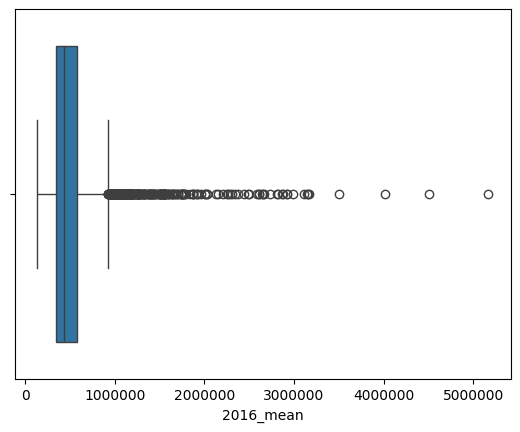

In [33]:
#use boxplot to inspect impact of outliers
sns.boxplot(data=health_prop_clean, x='2016_mean');
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)


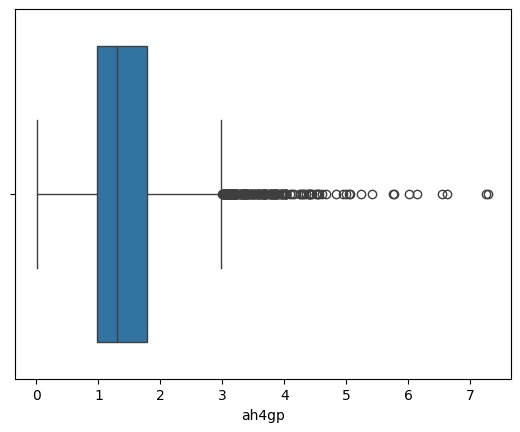

In [34]:
sns.boxplot(data=health_prop_clean, x='ah4gp');

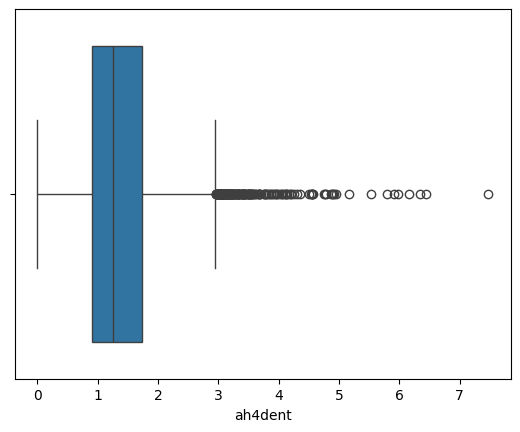

In [35]:
sns.boxplot(data=health_prop_clean, x='ah4dent');

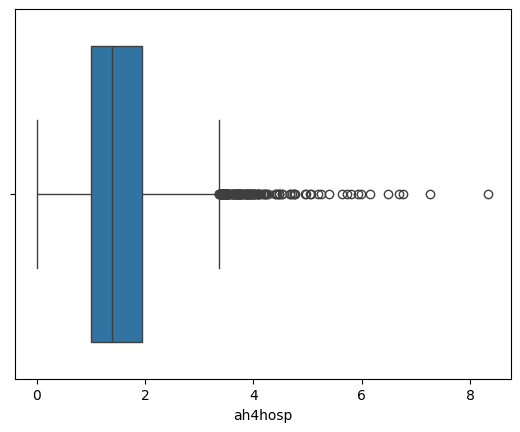

In [36]:
sns.boxplot(data=health_prop_clean, x='ah4hosp');

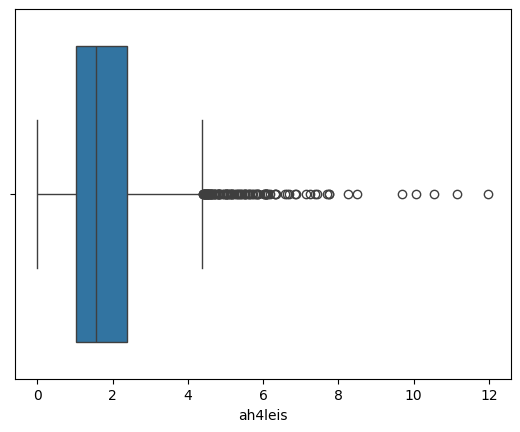

In [37]:
sns.boxplot(data=health_prop_clean, x='ah4leis');

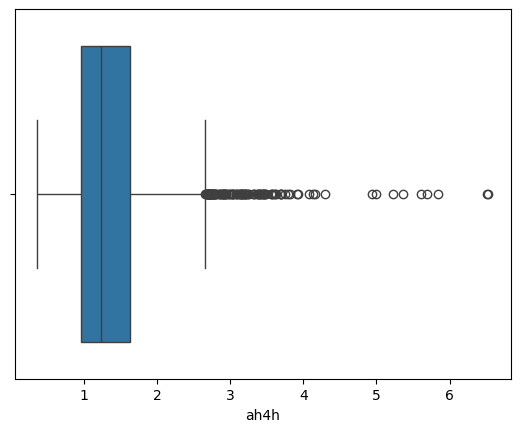

In [38]:
sns.boxplot(data=health_prop_clean, x='ah4h');

In [39]:
#remove outliers in 2016 mean using interquartle range method
#find intterquartile range
Q1 = health_prop_clean['2016_mean'].quantile(0.25)
Q3 = health_prop_clean['2016_mean'].quantile(0.75)
IQR = Q3 - Q1

In [40]:
#view Q1, Q3 and IQR
Q1, Q3, IQR

(np.float64(338492.5), np.float64(574418.75), np.float64(235926.25))

In [41]:
#find upper and lower limits
upper_limit = Q3 + (1.5 * IQR)
lower_limit = Q1 - (1.5 * IQR)
lower_limit, upper_limit

(np.float64(-15396.875), np.float64(928308.125))

In [42]:
#find outliers
outliers = health_prop_clean[(health_prop_clean['2016_mean'] > upper_limit) | (health_prop_clean['2016_mean'] < lower_limit)]
outliers

,LSOA21CD,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean,LSOA21NM,LAD22CD,LAD22NM
1,E01000001,0.6328,1.0316,0.9581,0.7487,0.3596,0.690745,967250.00,City of London 001A,E09000001,City of London
138,E01000136,1.0441,2.0149,1.9649,1.7549,1.5744,1.504175,1498750.00,Barnet 038B,E09000003,Barnet
146,E01000144,0.6623,0.9149,0.7330,0.7155,0.8325,0.694240,949687.50,Barnet 038C,E09000003,Barnet
147,E01000145,0.9320,1.0258,0.8513,1.0825,1.1010,0.889345,988125.00,Barnet 037A,E09000003,Barnet
202,E01000201,1.8067,1.6038,1.8913,1.6226,1.2768,1.495270,1509375.00,Barnet 028C,E09000003,Barnet
...,...,...,...,...,...,...,...,...,...,...,...
4817,E01004765,0.4084,1.2376,0.6640,0.4561,0.4218,0.593685,1018987.25,Westminster 013D,E09000033,Westminster
4820,E01033593,0.5939,0.7939,0.5922,0.6313,0.4317,0.555450,1012896.00,Westminster 015F,E09000033,Westminster
4822,E01035716,0.7626,0.9834,0.7882,0.7007,0.5325,0.691820,1666250.00,Westminster 013G,E09000033,Westminster
4823,E01035716,0.7626,0.9834,0.7882,0.7007,0.5325,0.691820,1871875.00,Westminster 013G,E09000033,Westminster


In [43]:
#trim the data
health_prop_clean_trim = health_prop_clean[(health_prop_clean['2016_mean'] < upper_limit) & (health_prop_clean['2016_mean'] > lower_limit)]


In [44]:
#check for difference in data
print('before removing outliers', health_prop_clean.shape)
print('after removing outliers', health_prop_clean_trim.shape)

before removing outliers (4778, 11)
after removing outliers (4461, 11)


# Data Exploration

The correlation between variables were explored at an LSOA scale using spearman’s rank. This was chosen as a simple statistical measure of correlation that does not require assumptions about distribution <a href="#ref2">[4]</a> The result of this were displayed on a heatmap with a mask covering duplicate records to make the data easier to interpret.  A color scheme of ‘RdBlu’ enabled easy identification of a positive or negative correlation. The rank value was also added to each square for clarity to the audience.  



**CORRELATION THROUGH SPEARMANS RANK**

In [45]:
#Calculate Spearmans Rank Correlation for all float data

health_prop_corr =health_prop_clean_trim[['ah4dent', 'ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].corr(method = 'spearman')
health_prop_corr


,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean
ah4dent,1.000000,0.557772,0.516030,0.633831,0.549510,0.800288,-0.218097
ah4gp,0.557772,1.000000,0.545328,0.624250,0.473259,0.778112,-0.081419
ah4hosp,0.516030,0.545328,1.000000,0.511814,0.492153,0.782421,-0.099861
ah4phar,0.633831,0.624250,0.511814,1.000000,0.524660,0.766670,-0.111044
ah4leis,0.549510,0.473259,0.492153,0.524660,1.000000,0.791198,-0.296402
ah4h,0.800288,0.778112,0.782421,0.766670,0.791198,1.000000,-0.221045
2016_mean,-0.218097,-0.081419,-0.099861,-0.111044,-0.296402,-0.221045,1.000000


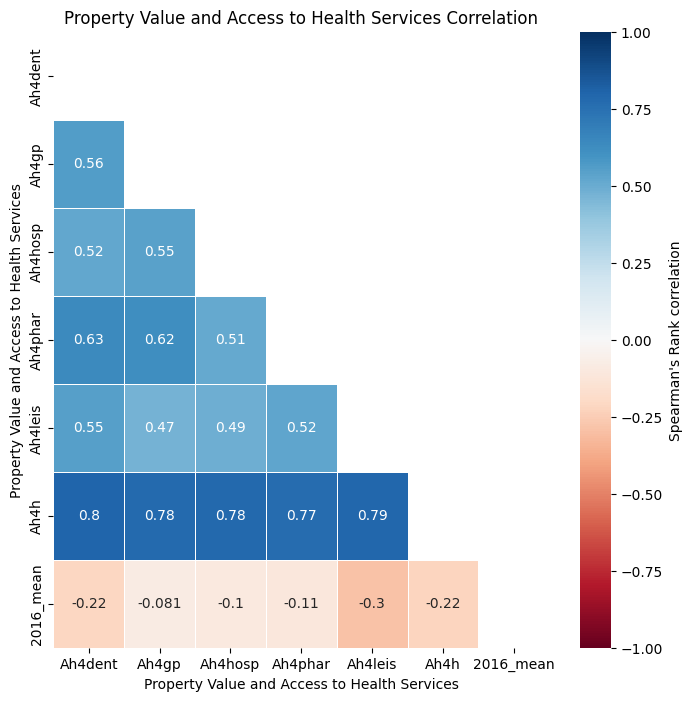

In [46]:
#Visualize spearmans correlation

# define plot size
fig,ax = plt.subplots(figsize=(8,8))

# define mask to apply to upper right hand corner of the plot
data_to_mask = np.triu(np.ones_like(health_prop_corr))

# define axis labels
x_axis_labels = health_prop_corr.columns
y_axis_labels = health_prop_corr.index


#capatlise each label is x and Y
x_axis_labels = [element.capitalize() for element in x_axis_labels]
y_axis_labels = [element.capitalize() for element in y_axis_labels]

# plot a heatmap of the correlation
sns.heatmap(health_prop_corr,
            #exband linewith for clarity
            linewidths=.5,
            # include spearmans value in squares
            annot=True,
            # define colourmap
            cmap='RdBu',
            # define value of minimum colour on cbar
            vmin=-1,
            # define value of maximum colour on cbar
            vmax=1,
            # add the mask
            mask=data_to_mask,
            # use the custom labels
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            # add a label to the cbar
            cbar_kws={'label': "Spearman's Rank correlation"},
            # plot on the axis we defined
            ax=ax)

# Set axis labels
ax.set(xlabel="Property Value and Access to Health Services",
       ylabel="Property Value and Access to Health Services",
      title ='Property Value and Access to Health Services Correlation' );


**Create Inner and Outer boruough classification**

In [47]:
#create column of inner or outer borough for additional information in visualisation
inner_london_boroughs = ('Camden', 'City of London', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 'Wandsworth', 'Westminster')

for index, row in health_prop_clean_trim.iterrows():
  if row['LAD22NM'] in inner_london_boroughs:
    health_prop_clean_trim.loc[index, 'inner_outer'] = 'Inner Borough'
  else:
    health_prop_clean_trim.loc[index, 'inner_outer'] = 'Outer Borough'

In [48]:
#check inner_outer has worked correctly
num_unique_categories = health_prop_clean_trim['inner_outer'].nunique()
print(f"Number of unique categories: {num_unique_categories}")

Number of unique categories: 2


# Non Spatial Visulation

The first visualization displays the relationship between median property value and individual variables of health access. Five smaller scatterplots have been included for each health service and one larger scatter plot for the overall weighted average access.

A scatterplot allows the relationship of two numerical variables to be clearly identified in a style easily recognizable to a non-technical audience <a href="#ref1">[5]</a>, and for each plot a regression line was added to easily identify the direction of the correlation. For the larger plot histograms of both variables were included on the secondary x and y axes to provide clarity on the individual distribution of each.

For additional detail the inner and outer boroughs of London were identified and added to the hue of the visualization. This adds additional information for the audience on the distribution of these points across London.

The key audience of this visualization is non-technical regional or national decision makers, who would assess the need for additional infrastructure in London while possibly lacking the expertise to deal with large data <a href="#ref1">[5]</a>. As such, when creating this visualization, accessibility and ease of interpretation were key drivers in many of the choices.

The color scheme of ‘colorblind’ was chosen to remain accessible to all, and hexagonal point markers used as often circular markers can be difficult to identify when overlapping <a href="#ref1">[6]</a>. In addition, we also added a level of opacity that ensures the points are less cluttered. We also reduced the amount of tick markers and included only one x and y axis title on the smaller graphs for a clearer aesthetic, and finally changed the orientation of the tick labels on the larger plot to ensure the visualization remained uncluttered and easy to interpret.


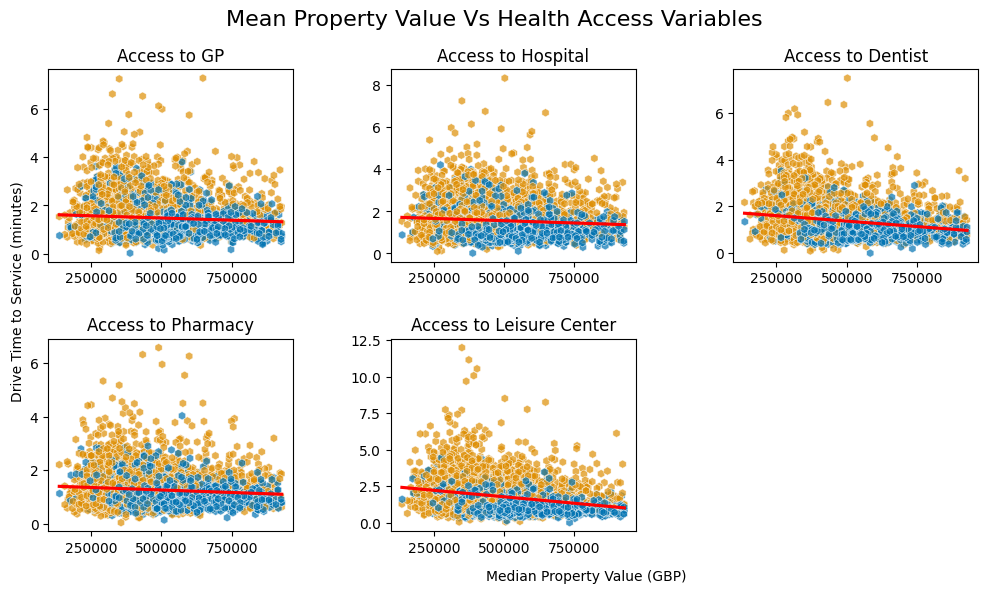

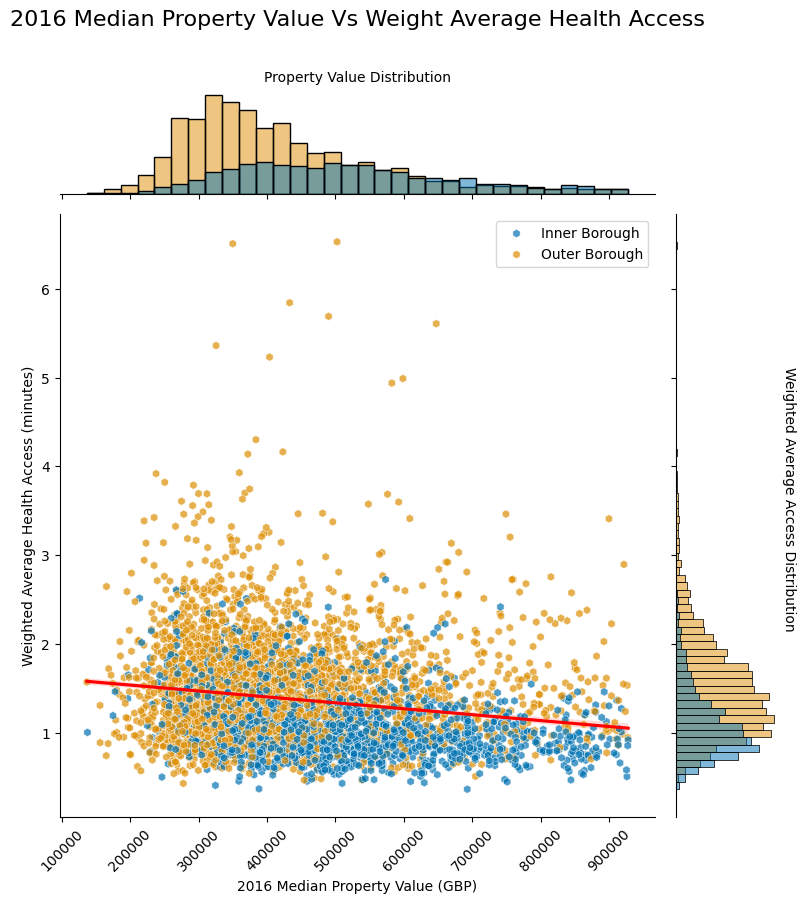

In [49]:
#create four subplots of health service individual variables
f,ax = plt.subplots(2,3, figsize=(12,6))
#widen space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#Add title to subplots
f.suptitle('Mean Property Value Vs Health Access Variables ', fontsize=16)


#plot distance to gp in plot 1
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4gp', hue='inner_outer', legend=False, marker= "h", palette='colorblind', alpha =0.7, ax=ax[0,0], ).locator_params(axis='x', nbins=3)
#Add Title to plot
ax[0, 0].set_title('Access to GP')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4gp", scatter=False, ax=ax[0,0], color='red')
#remove xaxis title
ax[0,0].set_xlabel('')
#remove yaxis title
ax[0,0].set_ylabel('')



#plot distance to hospital in plot 2
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4hosp', hue='inner_outer', legend=False, marker= "h", palette='colorblind', alpha =0.7, ax=ax[0,1]).locator_params(axis='x', nbins=3)
#Add title to plot
ax[0, 1].set_title('Access to Hospital')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4hosp", scatter=False, ax=ax[0,1], color='red')
#remove xaxis title
ax[0,1].set_xlabel('')
#remove yaxis title
ax[0,1].set_ylabel('')

#plot distance to hospital in plot 3
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4dent', hue='inner_outer', legend=False, marker= "h", palette='colorblind', alpha =0.7, ax=ax[0,2]).locator_params(axis='x', nbins=3)
#Add title to plot
ax[0,2].set_title('Access to Dentist')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4dent", scatter=False, ax=ax[0,2], color='red')
#remove xaxis title
ax[0,2].set_xlabel('')
#remove yaxis title
ax[0,2].set_ylabel('')



#plot distance to pharmacy in plot 4
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4phar', hue='inner_outer', legend=False,  marker= "h", palette='colorblind', alpha =0.7, ax=ax[1,0]).locator_params(axis='x', nbins=3)
#add plot title
ax[1,0 ].set_title('Access to Pharmacy')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4phar", scatter=False, ax=ax[1,0], color='red')
#remove xaxis title
ax[1,0].set_xlabel('')
#center y label to use for four plots
ax[1,0].set_ylabel('Drive Time to Service (minutes)', y=1.25,fontsize=10)

#plot distance to leisure center in plot 5
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4leis', hue='inner_outer', legend=False,  marker= "h", palette='colorblind', alpha =0.7, ax=ax[1,1]).locator_params(axis='x', nbins=3)
#add plot title
ax[1, 1].set_title('Access to Leisure Center')
#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4leis", scatter=False, ax=ax[1,1], color='red')
#center x label to use for four plots
ax[1,1].set_xlabel('Median Property Value (GBP)', labelpad=10, x=.8,fontsize=10)
#remove yaxis title
ax[1,1].set_ylabel('')

#Hide axis of plot 6
ax[1,2].axis('off')



#LARGE PLOT


#plot overal health access score vs property value
g=sns.JointGrid(data=health_prop_clean_trim, x='2016_mean', y='ah4h', hue="inner_outer", height =8)

#add regression line
sns.regplot(data=health_prop_clean_trim, x='2016_mean', y="ah4h", scatter=False, ax=g.ax_joint, color='red')

#remove scientific formating to include full house price
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)

#plot health access score vs property value as scatter plot
sns.scatterplot(data=health_prop_clean_trim, x='2016_mean', y='ah4h', hue='inner_outer', marker= "h", palette='colorblind', alpha =0.7, ax=g.ax_joint)

#plothistograms on x-axis showing distribution of house price
sns.histplot(data=health_prop_clean_trim, x='2016_mean', hue="inner_outer", palette='colorblind', ax=g.ax_marg_x)

#plot histogram on y-axis showing distribution of weighted health access
sns.histplot(data=health_prop_clean_trim, y='ah4h', hue="inner_outer", palette='colorblind', ax=g.ax_marg_y)

#Remove legend from axis histograms
g.ax_marg_y.legend_.remove()
g.ax_marg_x.legend_.remove()

#Remove title from main legend
g.ax_joint.get_legend().set_title("")

#add title to property value distribution and set size
g.ax_marg_x.set_title('Property Value Distribution', fontsize=10)

#add title to weighted average Health Access Score distribution, set size, rotate and align to axis using x and y
g.ax_marg_y.set_title('Weighted Average Access Distribution', fontsize=10, rotation=270, y=0.3, x=1.1)

#Edit Axis Labels and set size
g.ax_joint.set_ylabel('Weighted Average Health Access (minutes)', fontsize=10)
g.ax_joint.set_xlabel('2016 Median Property Value (GBP)', fontsize=10);

#change orientation of x-axis ticks
g.ax_joint.tick_params(axis='x', rotation=45)

#add title to map and set position and fontsize
g.ax_joint.set_title('2016 Median Property Value Vs Weight Average Health Access', fontsize=16, y=1.3);

# LOCAL AUTHORITY DISTRICT (LAD) VISUALISTAION

#Additional Pre-processing for Spatial Visualization

To investigate this correlation at a different spatial scale, some extra pre-processing was required. The first step was to group the data into Local Authority Districts (LADs). This was done through the LAD21 code and the variables aggregated by mean. Mean was chosen as the most appropriate due to the nature and distribution of the data.
Additionally, median property price was divided by 100,000 to bring it to a comparable value with other data sets to aid in visualization, and the CSV file was joined with the geojson file to enable an accurate spatial projection.


**COMBINING LAD BOUNDARY GEOMETRY AND HEALTH ACCESS Vs PROPERTY VALUE**

In [50]:
#read in shape file of boundaries
# Data downloaded from https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-may-2024-boundaries-uk-bfe-2/explore?location=51.468470%2C-0.040938%2C9.90
shp = gpd.read_file('https://github.com/Jonathan-C-Barrett/GEOG5990M/raw/main/Local_Authority_Districts_May_2024_Boundaries_UK_BFE_2410925873296837173.geojson')



In [51]:
#inspect data
shp.head()

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,geometry
0,92,E07000068,Brentwood,,558560,196070,0.290091,51.6411,"POLYGON ((0.3357 51.71415, 0.33589 51.71378, 0..."
1,284,E09000021,Kingston upon Thames,,519508,167389,-0.283670,51.3930,"POLYGON ((-0.25349 51.4366, -0.25347 51.43656,..."
2,278,E09000015,Harrow,,515359,189736,-0.335980,51.5947,"POLYGON ((-0.30542 51.63338, -0.3054 51.63332,..."
3,201,E07000215,Tandridge,,536362,150328,-0.048090,51.2358,"POLYGON ((-0.02485 51.33851, -0.02482 51.33849..."
4,195,E07000209,Guildford,,500408,151481,-0.562570,51.2537,"POLYGON ((-0.48262 51.33046, -0.4825 51.33041,..."


In [52]:
#group property and health data by Local Authority District
health_prop_LAD = health_prop_clean_trim.groupby('LAD22NM').mean(numeric_only=True)
health_prop_LAD.head(n=35)

,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean
LAD22NM,,,,,,,
Barking and Dagenham,1.598126,1.311151,1.365741,1.327178,2.209175,1.385457,274613.981308
Barnet,1.331989,1.483851,1.962344,1.304666,1.578824,1.388160,519542.808594
Bexley,1.748908,1.916312,2.323867,1.519910,2.516622,1.803297,324348.652778
Brent,1.299986,1.380337,1.697324,1.169485,1.890386,1.334510,466983.843621
Bromley,1.828510,1.885469,2.170716,1.779859,2.252039,1.781724,440093.848214
Camden,0.979445,1.093353,1.034232,0.918976,0.998115,0.908970,647830.931271
City of London,0.715080,1.223700,1.013060,0.731580,0.485840,0.772981,705773.750000
Croydon,1.657061,1.886106,1.807335,1.516211,2.240880,1.633664,357257.299923
Ealing,1.334173,1.232299,1.601555,1.192011,1.824164,1.286032,467836.128947


In [53]:
#convert 2016 property mean to more easily comparable by dividing by /100,000
health_prop_LAD['2016_mean'] = health_prop_LAD['2016_mean']/100000
health_prop_LAD.head()


,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean
LAD22NM,,,,,,,
Barking and Dagenham,1.598126,1.311151,1.365741,1.327178,2.209175,1.385457,2.746140
Barnet,1.331989,1.483851,1.962344,1.304666,1.578824,1.388160,5.195428
Bexley,1.748908,1.916312,2.323867,1.519910,2.516622,1.803297,3.243487
Brent,1.299986,1.380337,1.697324,1.169485,1.890386,1.334510,4.669838
Bromley,1.828510,1.885469,2.170716,1.779859,2.252039,1.781724,4.400938


In [54]:
#explore basic statistics
health_prop_LAD.describe()

,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,1.348745,1.447213,1.509159,1.235289,1.758412,1.310079,4.741198
std,0.342006,0.322566,0.375591,0.275162,0.629532,0.323093,1.126990
min,0.715080,0.911941,0.940939,0.731580,0.485840,0.772981,2.746140
25%,1.127499,1.223700,1.180450,1.036034,1.243359,1.040705,3.962139
50%,1.334173,1.380337,1.512774,1.270928,1.808005,1.333760,4.667691
75%,1.539174,1.744391,1.764304,1.393633,2.209175,1.492741,5.195428
max,2.185296,2.009409,2.323867,1.829075,3.211153,1.960492,7.071994


In [55]:
#Cobine property and Health access data with geoson LAD boundaries and check all 33 Boroughs present
health_prop_LAD_ldn = pd.merge(shp, health_prop_LAD, left_on='LAD24NM', right_on='LAD22NM', how='right')
health_prop_LAD_ldn.head(n=35)

,FID,LAD24CD,LAD24NM,LAD24NMW,BNG_E,BNG_N,LONG,LAT,geometry,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean
0,265,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.5456,"POLYGON ((0.1481 51.59653, 0.14807 51.59636, 0...",1.598126,1.311151,1.365741,1.327178,2.209175,1.385457,2.746140
1,266,E09000003,Barnet,,523473,191752,-0.218190,51.6111,"POLYGON ((-0.19987 51.67017, -0.19968 51.66986...",1.331989,1.483851,1.962344,1.304666,1.578824,1.388160,5.195428
2,267,E09000004,Bexley,,549202,175434,0.146212,51.4582,"POLYGON ((0.15928 51.50871, 0.15997 51.50869, ...",1.748908,1.916312,2.323867,1.519910,2.516622,1.803297,3.243487
3,268,E09000005,Brent,,519615,186465,-0.275680,51.5644,"POLYGON ((-0.26482 51.59827, -0.2647 51.59817,...",1.299986,1.380337,1.697324,1.169485,1.890386,1.334510,4.669838
4,269,E09000006,Bromley,,542036,165707,0.039246,51.3727,"POLYGON ((0.03059 51.44432, 0.03063 51.4443, 0...",1.828510,1.885469,2.170716,1.779859,2.252039,1.781724,4.400938
5,270,E09000007,Camden,,527491,184283,-0.162910,51.5430,"POLYGON ((-0.16598 51.57274, -0.16589 51.57272...",0.979445,1.093353,1.034232,0.918976,0.998115,0.908970,6.478309
6,264,E09000001,City of London,,532382,181358,-0.093510,51.5156,"POLYGON ((-0.09669 51.52319, -0.09668 51.52317...",0.715080,1.223700,1.013060,0.731580,0.485840,0.772981,7.057737
7,271,E09000008,Croydon,,533922,164745,-0.077610,51.3660,"POLYGON ((-0.11136 51.42317, -0.11093 51.42315...",1.657061,1.886106,1.807335,1.516211,2.240880,1.633664,3.572573
8,272,E09000009,Ealing,,517055,181959,-0.314100,51.5244,"POLYGON ((-0.34553 51.55843, -0.34551 51.55843...",1.334173,1.232299,1.601555,1.192011,1.824164,1.286032,4.678361
9,273,E09000010,Enfield,,532831,196198,-0.081440,51.6489,"POLYGON ((-0.10576 51.69188, -0.10574 51.69182...",1.642880,1.865814,1.764304,1.497207,2.012272,1.581021,3.996847


In [ ]:
#check data on leaflet map
health_prop_LAD_ldn.explore()

#Exploration
To explore the effect of the spatial aggregation a spearman’s rank correlation was again undertaken using the same visual decisions on the heatmap to ensure accessibility of the results.

Following this a K means clustering was undertaken to group LADs together. The ‘elbow method’ was used to determine the optimal number of clusters where minimal variation was observed at the lowest cluster count. K-means was selected due to its wide use as an unsupervised learning algorithm with the elbow method being suitable for smaller k values <a href="#ref1">[7]</a>.   

Four clear clusters were identified, of which the median was then calculated and plotted on a bar chart to easily identify the characteristics of each cluster. An appropriate name was then assigned, to make the characteristics of each clear for the audience.


**EXPLORE CORRELATION AT LAD SCALE**

In [57]:
#Examine correlation between data at LAD level using Spearmans rank
health_prop_LADcorr = health_prop_LAD_ldn[['ah4dent','ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis', 'ah4h','2016_mean']].corr(method = 'spearman')
health_prop_LADcorr

,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,ah4h,2016_mean
ah4dent,1.000000,0.855615,0.783422,0.902406,0.877340,0.915107,-0.856952
ah4gp,0.855615,1.000000,0.764372,0.937834,0.862634,0.931818,-0.635695
ah4hosp,0.783422,0.764372,1.000000,0.842914,0.803476,0.900735,-0.657420
ah4phar,0.902406,0.937834,0.842914,1.000000,0.914104,0.972928,-0.687500
ah4leis,0.877340,0.862634,0.803476,0.914104,1.000000,0.948195,-0.740976
ah4h,0.915107,0.931818,0.900735,0.972928,0.948195,1.000000,-0.745321
2016_mean,-0.856952,-0.635695,-0.657420,-0.687500,-0.740976,-0.745321,1.000000


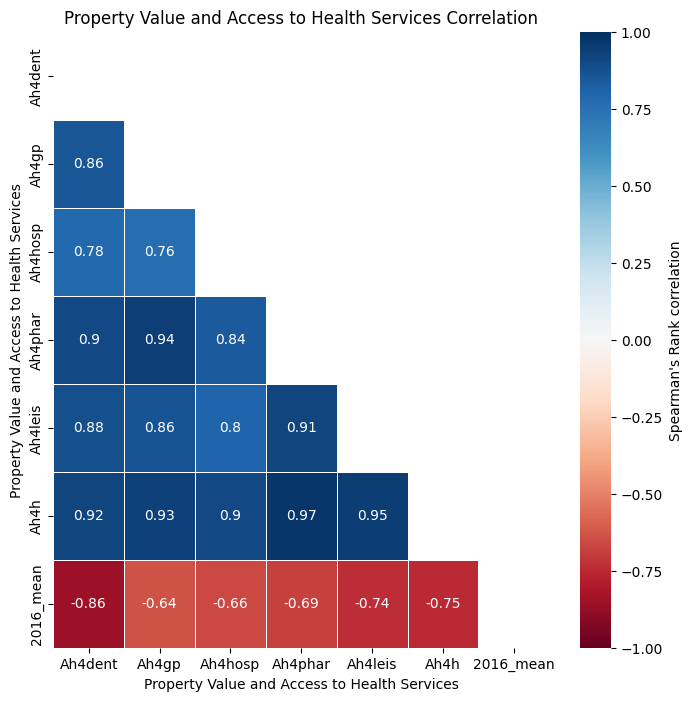

In [58]:
#visualise correlation
# define plot size
fig,ax = plt.subplots(figsize=(8,8))

# define mask to apply to upper right hand corner of the plot
data_to_mask = np.triu(np.ones_like(health_prop_LADcorr))

# define axis labels
x_axis_labels = health_prop_LADcorr.columns
y_axis_labels = health_prop_LADcorr.index


#capatlise each label is x and Y
x_axis_labels = [element.capitalize() for element in x_axis_labels]
y_axis_labels = [element.capitalize() for element in y_axis_labels]

# plot a heatmap of the correlation
sns.heatmap(health_prop_LADcorr,
            #exband linewith for clarity
            linewidths=.5,
            # include spearmans value in sqaures
            annot=True,
            # define colourmap
            cmap='RdBu',
            # define value of minimum colour on cbar
            vmin=-1,
            # define value of maximum colour on cbar
            vmax=1,
            # add the mask
            mask=data_to_mask,
            # use the custom labels
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,
            # add a label to the cbar
            cbar_kws={'label': "Spearman's Rank correlation"},
            # plot on the axis we defined
            ax=ax)

# Set axis labels
ax.set(xlabel="Property Value and Access to Health Services",
       ylabel="Property Value and Access to Health Services",
      title ='Property Value and Access to Health Services Correlation' );


**K- Means Classification**

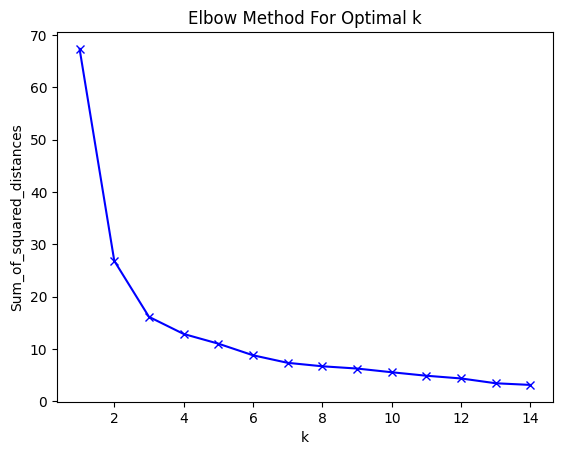

In [59]:
#Decide on number of clusters through elbow method
# create an empty list
Sum_of_squared_distances = []

# get a range of numbers from 1 to 15
K = range(1,15)
#for each number in the range 1 to 15create a k-means model with that number of clusters and set a random state
for k in K:
    km = cluster.KMeans(n_clusters=k, init="random", random_state=123)
    # fit the model using the variables from database
    km = km.fit(health_prop_LAD_ldn[['ah4dent','ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean']].values)
    # calculate the sum of the squared distances and add this to the 'Sum_of_squared_distances' list
    Sum_of_squared_distances.append(km.inertia_)

# plot the sum of squared distances against the number of clusters
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [60]:
# run the model with minimum needed for minimal change in this instance 4
km4 = cluster.KMeans(n_clusters=4,init="random", random_state=123)
km4cls = km4.fit(health_prop_LAD_ldn[['ah4dent','ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean']].values)

In [61]:
#create a new column in db with cluster label
health_prop_LAD_ldn['cluster'] = km4cls.labels_
health_prop_LAD_ldn['cluster'].head()

,cluster
0,0
1,2
2,3
3,2
4,3


In [ ]:
# Create a pairplot which shows relationship between variables captured by clustering
sns.pairplot(health_prop_LAD_ldn[['ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean','cluster']],
             hue='cluster',
             palette='Dark2',
            height=5);

In [63]:
#groupby cluster to get the median value of each variable by cluster
health_prop_LAD_clusters_median=health_prop_LAD_ldn.groupby('cluster')[['ah4dent','ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean']].median().reset_index()

In [64]:
#explore median values
health_prop_LAD_clusters_median

,cluster,ah4dent,ah4gp,ah4hosp,ah4phar,ah4leis,2016_mean
0,0,1.502206,1.486459,1.526510,1.294858,1.911418,3.898473
1,1,0.979445,1.093353,1.034232,0.910172,0.998115,6.478309
2,2,1.306498,1.318163,1.471693,1.180748,1.693415,4.784876
3,3,1.748908,1.886106,1.926804,1.572043,2.516622,3.966118


In [65]:
# transform data to a long format to plot
health_prop_LAD_clusters_median_to_plot =pd.melt(health_prop_LAD_clusters_median,id_vars='cluster',
                                            value_vars=['ah4dent','ah4gp', 'ah4hosp', 'ah4phar', 'ah4leis','2016_mean'])

In [66]:
# check data
health_prop_LAD_clusters_median_to_plot.head()

,cluster,variable,value
0,0,ah4dent,1.502206
1,1,ah4dent,0.979445
2,2,ah4dent,1.306498
3,3,ah4dent,1.748908
4,0,ah4gp,1.486459


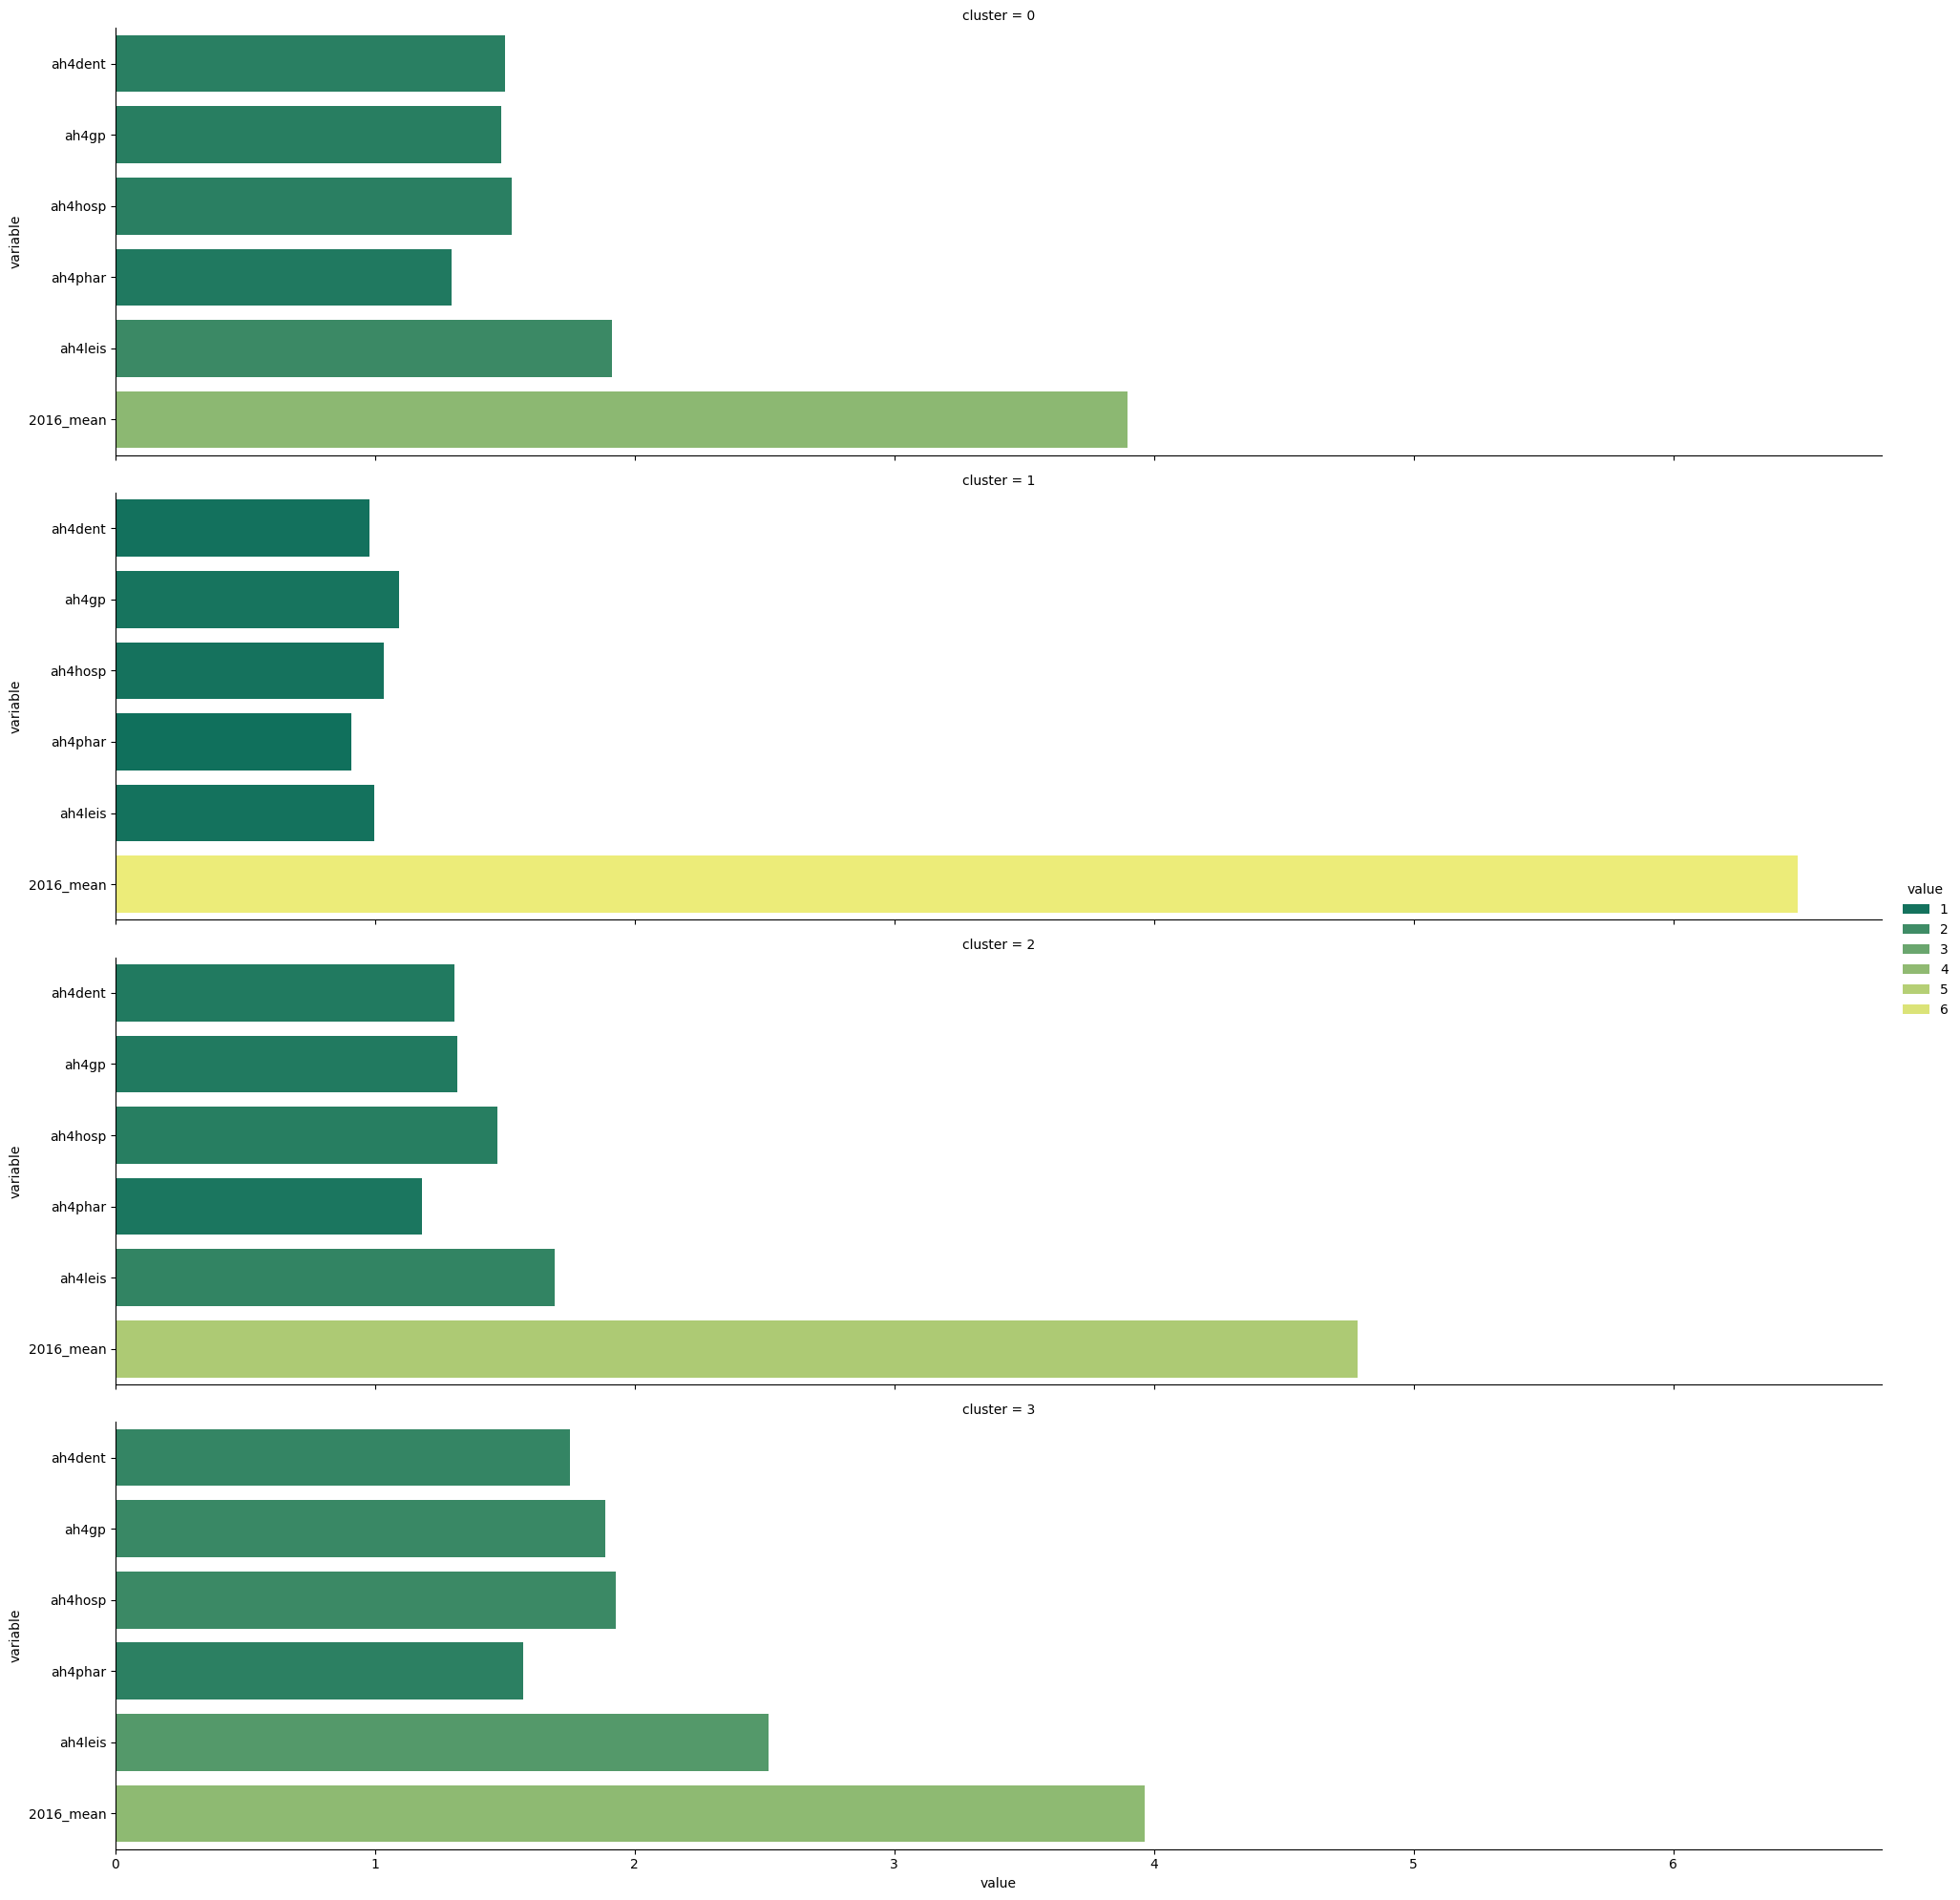

In [67]:
# Plot a faceted bar chart, where each row is a different cluster

sns.catplot(health_prop_LAD_clusters_median_to_plot,
            row='cluster',
            y='variable',
            x='value',
            kind='bar',
            aspect=4,
            hue='value',
            palette='summer');



In [68]:
#changecluster naming
#create empty column
health_prop_LAD_ldn['Cluster_description']=""

In [69]:
#update names of each cluster
health_prop_LAD_ldn.loc[health_prop_LAD_ldn['cluster']==0,'Cluster_description']='Medium Value Medium  Access'
health_prop_LAD_ldn.loc[health_prop_LAD_ldn['cluster']==1,'Cluster_description']='High Value Good Access'
health_prop_LAD_ldn.loc[health_prop_LAD_ldn['cluster']==2,'Cluster_description']='Medium High Value Medium Access'
health_prop_LAD_ldn.loc[health_prop_LAD_ldn['cluster']==3,'Cluster_description']='Low Value Lower Access'

# Spatial Visualisation
The second visualization provides two choropleth maps of equal size that illustrate the spatial variation in each of the four clusters in the first map, and in the second the weighted mean of health access for each LAD.

The intended audience for this being local decision makers to identify how their ward compares with others within London, a selection of stylistic and practical choices were made to ensure optimum accessibility and useability.

Initially the CRS of the data frame was converted to EPSG:3857 allowing its use with a basemap. The basemap selected was CartoDB from ‘contexttily’ under the option ‘Positron’. This map provided place names while remaining unobtrusive to the main visualization, and through adding a level of opacity to the choropleth maps, provides local context to the audience.  

Virdis color palette was used for the clusters as this was designed to be easily distinguishable by individuals with common forms of color blindness <a href="#ref1">[8]</a> while still offering differentiation in color. Also, due to the nature of the data a not too strong sequential palette was preferable.

For the weighted mean access, magma was chosen as another palette that offers accessibility to people with common forms of colorblindness but differentiates it from the other choropleth map and offers a stronger sense of sequentiality <a href="#ref1">[9]</a>.

Some final aesthetic choices that were made for useability were that on both maps’ axis were removed as these overcomplicated the plots, a North Arrow was added to aid in locality, the legend was moved to ensure none of the map area was covered, and finally the color bar was resized to offer enough detail while not overpowering the map.


In [70]:
#Check CRS of datafame
health_prop_LAD_ldn.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [71]:
#convert crs to  Web Mercator projection (epsg=3857) to work with base maps
health_prop_LAD_ldn_WM = health_prop_LAD_ldn.to_crs(epsg=3857)

In [72]:
#check new crs
health_prop_LAD_ldn_WM.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

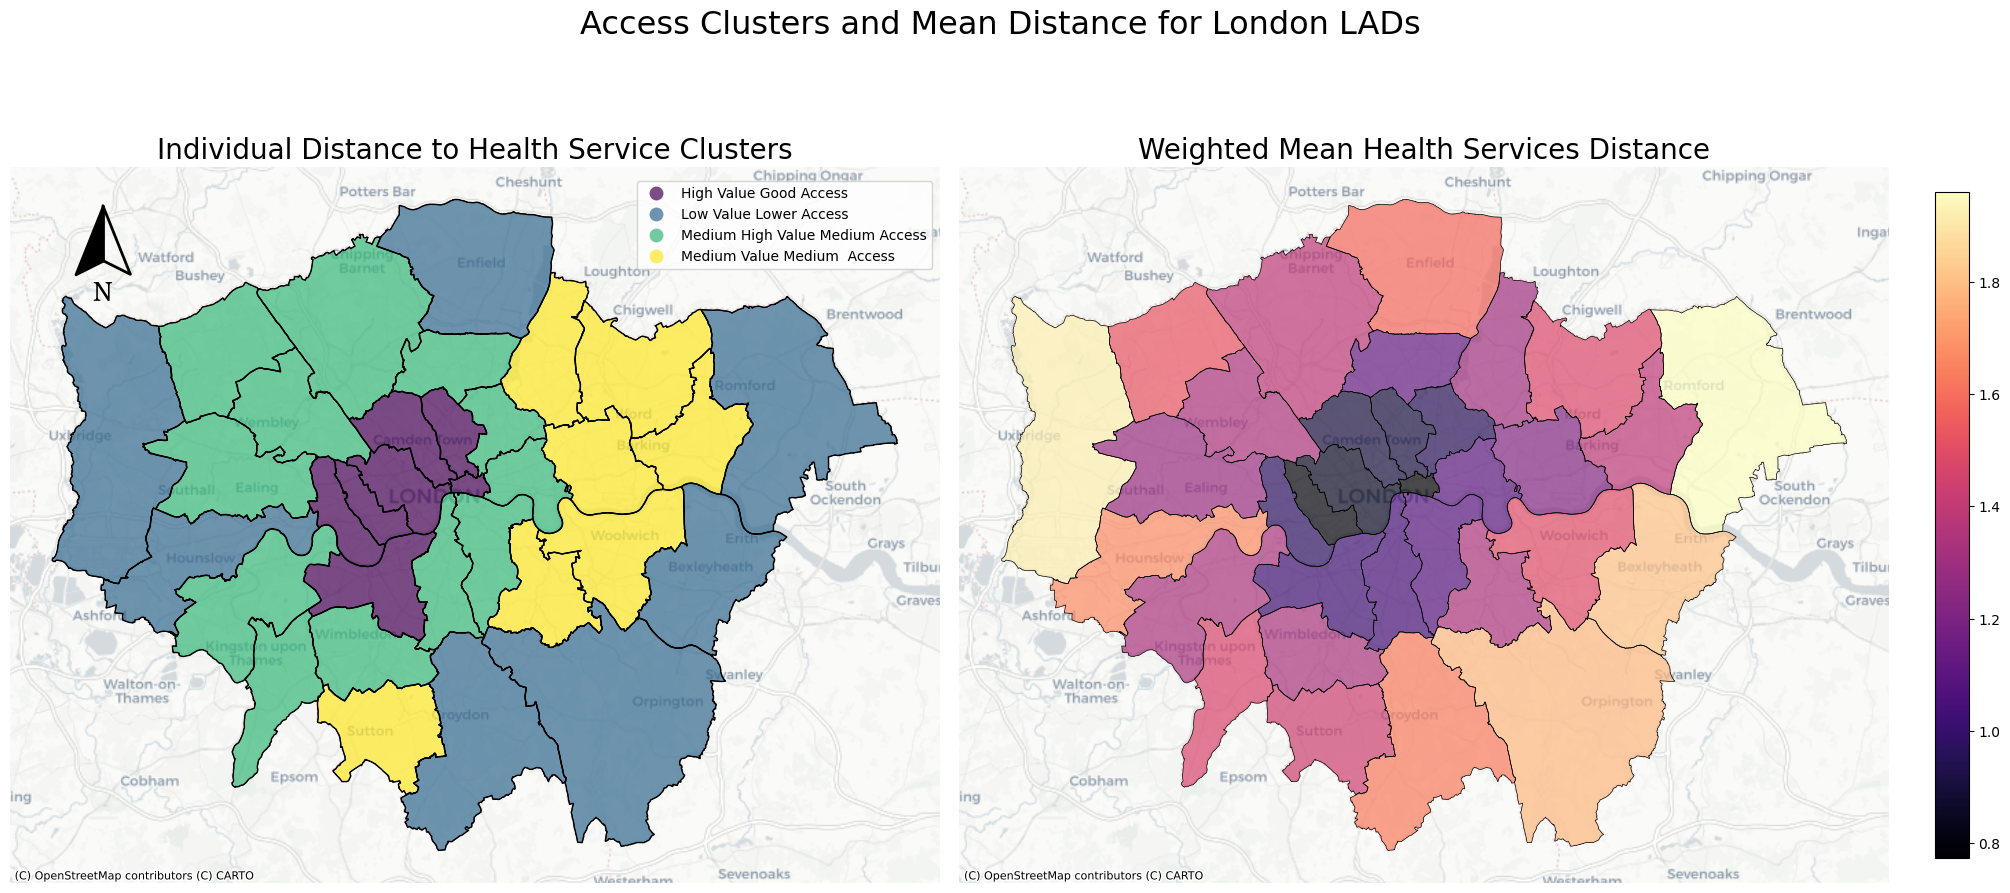

In [73]:
# Data Visualisation

#create a figure with 3 subplots
f,ax = plt.subplots(1,2, figsize=(20,10), layout='constrained')
f.suptitle('Access Clusters and Mean Distance for London LADs ', fontsize=23)

#plot cluster description
health_prop_LAD_ldn_WM.plot(ax=ax[0], column ='Cluster_description', alpha=0.7, cmap='viridis', legend=True)
#add basemap
ctx.add_basemap(ax=ax[0], source=ctx.providers.CartoDB.Positron, crs=health_prop_LAD_ldn_WM.crs)
#plot LAD boundaries
health_prop_LAD_ldn_WM.boundary.plot(ax=ax[0], color='black', linewidth=.5)
# add title
ax[0].set_title('Individual Distance to Health Service Clusters', fontsize=20)
# add a North arrow
add_north_arrow(ax=ax[0], scale=.75, xlim_pos=0.1, ylim_pos=.85, color='#000', text_scaler=2, text_yT=-1.25)
# position legend
ax[0].get_legend().set_bbox_to_anchor((1.0, 0.99))
#plot LAD boundaries
health_prop_LAD_ldn_WM.boundary.plot(ax=ax[0], color='black', linewidth=1)


#plot health access score
health_prop_LAD_ldn_WM.plot(ax=ax[1], column ='ah4h', alpha=0.7, legend=True, cmap='magma',legend_kwds={'shrink': 0.7})
#add basemap
ctx.add_basemap(ax=ax[1], source=ctx.providers.CartoDB.Positron, crs=health_prop_LAD_ldn_WM.crs)
#plot LAD boundaries
health_prop_LAD_ldn_WM.boundary.plot(ax=ax[1], color='black', linewidth=.5)
# add title
ax[1].set_title('Weighted Mean Health Services Distance', fontsize=20)
# make axis invisible for subplot 1
ax[0].set_axis_off()
# make axis invisible for subplot 2
ax[1].set_axis_off()

plt.show();

#Results and Conclusions
From the exploration and visualization of this data we can draw some conclusions and observations. First is that there does appear to be a correlation between property value and access to health services although this is largely affected by scale.

At the smaller LSOA scale the correlation is far more variable and less conclusive, while at the aggregated LAD scale a negative correlation is much more pronounced.

Second is that at both scales’ dentists, leisure centers and pharmacies have a stronger correlation with house price than GPs or hospitals. This may be due to the private ownership of many of these facilities, where profitability is the focus.

Finally, we can observe that there is a spatial component to health access across London, with more central areas providing the best access, while access generally declines as you near the outskirts of the city.  


#Limitations
It is the hope that this project provides a useful exploration of how access to healthcare may affect house prices and highlights areas that may require more infrastructural support, however this report also comes with some limitations.

Chief among these is that the data only provides distance to service and not the capacity of the service itself <a href="#ref1">[1]</a>. Equally the list of services is not exhaustive, and the report could be improved in further inclusions.

Finally, the weighting of the overall distance is based on assumptions of the author and previous research, however exact weighting is difficult to justify <a href="#ref1">[1]</a> and therefore could be improved with further research.

Even with these limitations, however, access to healthcare is a right for all <a href="#ref1">[10]</a> and not just for the wealthiest, and so in the future hopefully more work can be done on equality of healthcare across London.



This is an example block of mardown text I want to reference <a href="#ref1">[1]</a>. I might need to add some more citations <a href="#ref2">[2]</a><a href="#ref2">[3]</a>



Data Visualisation
- Don't forget to present your final two data visualisation (one spatial and one non-spatial) and the justifications about the decisions you made whilst preparing and visualising the data.

## References
<p><a href="add_url_here">[1]</a>Daras, K., Green, M.A., Davies, A., Barr, B. and Singleton, A., 2019. Open data on health-related neighbourhood features in Great Britain. Scientific data, 6(1), p.107.</p>

<p><a href="http://dx.doi.org/10.2139/ssrn.2785400">[2]</a> Kajuth, Florian and Schmidt, Tobias, Seasonality in House Prices (2011). Bundesbank Series 1 Discussion Paper No. 2011,08,</p>

<p><a href="add_url_here">[3]</a>Dash, C.S.K., Behera, A.K., Dehuri, S. and Ghosh, A., 2023. An outliers detection and elimination framework in classification task of data mining. Decision Analytics Journal, 6, p.100164.</p>

<p><a href="add_url_here">[4]</a> Xiao, C., Ye, J., Esteves, R. M., and Rong, C. (2016) Using Spearman's correlation coefficients for exploratory data analysis on big dataset. Concurrency Computat.: Pract. Exper., 28: 3866–3878.</p>

<p><a href="add_url_here">[5]</a>Srivastava, D., 2023. An introduction to data visualization tools and techniques in various domains. International Journal of Computer Trends and Technology, 71(4), pp.125-130.</p>

<p><a href="https://data.europa.eu/apps/data-visualisation-guide/handling-overlap-in-scatter-plots">[6]</a>European Data. 2023. Data-visualisation-guide handling-overlap-in-scatter-plots. Accessed July 2025</p>

<p><a href="add_url_here">[7]</a>Cui, M., 2020. Introduction to the k-means clustering algorithm based on the elbow method. Accounting, Auditing and Finance, 1(1), pp.5-8.3</p>

<p><a href="https://pos.sissa.it/guidelines.pdf">[8]</a>Cherenkov Telescope Array Observatory (CTAO). (October, 2020). Best Practices for Colour Blind Friendly Publications & Descriptions.</p>

<p><a href="https://matplotlib.org/stable/users/explain/colors/colormaps.html">[9]</a>Matplotlib. Matplotlib development team. 2012-2025. Available at  https://matplotlib.org/stable/users/explain/colors/colormaps.html Accessed July 2025</p>

<p><a href="add_url_here">[10]</a>Goddard, M. and Smith, P., 2001. Equity of access to health care services:: Theory and evidence from the UK. Social science & medicine, 53(9), pp.1149-1162</p>


<p><a href="https://github.com/FrancescaPontin/GEOG5990">[11]</a>GEOG5990M course materials</p>
<p><a href="add_url_here">[12]</a>Citation 3</p>